# Production-Grade Model Training Pipeline

**Objective:** Train production-ready fraud detection models using a nested cross-validation strategy with rigorous anti-leakage measures.
**Models:** XGBoost, LightGBM (Conditional), Random Forest  
**Optimization:** Optuna Hyperparameter Tuning  
**Evaluation:** ROC-AUC, Precision-Recall, Business Cost Analysis

---

### Table of Contents
1. [Setup & Imports](#1)
2. [Data Loading & Verification](#2)
3. [Feature Categorization](#3)
4. [Temporal Split (Leakage Prevention)](#4)
5. [Preprocessing Pipeline](#5)
6. [Nested Cross-Validation Strategy](#6)
7. [Optuna Objectives](#7)
8. [Hyperparameter Optimization](#8)
9. [Final Training](#9)
10. [Evaluation on Test Set](#10)
11. [Visualizations](#11)
12. [Model Comparison & Selection](#12)
13. [Interpretability (SHAP)](#13)
14. [Artifact Registry](#14)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import logging
import warnings
import os
import sys
import time

# SKLearn
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, confusion_matrix, 
    classification_report, precision_score, recall_score, f1_score, 
    average_precision_score, matthews_corrcoef
)

# Models
import xgboost as xgb
try:
    import lightgbm as lgb
    LGBM_AVAILABLE = True
except (ImportError, OSError) as e:
    LGBM_AVAILABLE = False
    print(f"Warning: LightGBM could not be imported (likely missing libomp). It will be skipped. Error: {e}")

from sklearn.ensemble import RandomForestClassifier

# Optimization
import optuna
from optuna.samplers import TPESampler

# Setup
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

# constants
SEED = 42
np.random.seed(SEED)

# Paths
INPUT_PATH = "../data/processed/features_engineered.parquet"
METADATA_PATH = "../data/metadata/feature_metadata.json"
MODEL_PATH = "../artifacts/models"
METRICS_PATH = "../artifacts/metrics"
LOGS_PATH = "../artifacts/logs"

for p in [MODEL_PATH, METRICS_PATH, LOGS_PATH]:
    os.makedirs(p, exist_ok=True)

print("Environment initialized.")

Environment initialized.


## 2. Load Engineered Data

In [2]:
# Load Data
logger.info("Loading dataset...")
df = pd.read_parquet(INPUT_PATH)

# Load Metadata
with open(METADATA_PATH, 'r') as f:
    metadata = json.load(f)

# Basic Stats
n_rows, n_cols = df.shape
fraud_rate = df['is_fraud'].mean()

print(f"Shape: {df.shape}")
print(f"Fraud Rate: {fraud_rate:.4%}")
print(f"Date Range: {df['trans_date_trans_time'].min()} to {df['trans_date_trans_time'].max()}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Verified Checks
assert df.isnull().sum().sum() == 0, "Unexpected missing values found!"

2025-12-21 22:40:11,357 - INFO - Loading dataset...


Shape: (1296675, 58)
Fraud Rate: 0.5789%
Date Range: 2019-01-01 00:00:18 to 2020-06-21 12:13:37
Memory Usage: 474.87 MB


## 3. Feature Categorization

In [3]:
target = 'is_fraud'
drop_cols = ['trans_date_trans_time', target]

# Identify Numerical and Categorical columns based on dtypes
# We strictly use the engineered set. 
cat_cols = df.select_dtypes(include=['category', 'object', 'string']).columns.tolist()
num_cols = df.select_dtypes(include=np.number).columns.tolist()
num_cols = [c for c in num_cols if c not in drop_cols]
cat_cols = [c for c in cat_cols if c not in drop_cols]

X_cols = num_cols + cat_cols

print(f"Total Features: {len(X_cols)}")
print(f"Numerical: {len(num_cols)}")
print(f"Categorical: {len(cat_cols)}")

# Sanity Check
assert len(set(num_cols).intersection(set(cat_cols))) == 0

Total Features: 56
Numerical: 49
Categorical: 7


## 4. Temporal Train/Test Split
**CRITICAL:** We use a time-based split to simulate production reality. Random splitting would cause future data leakage into the training set.

In [4]:
# Sort by time
df = df.sort_values('trans_date_trans_time').reset_index(drop=True)

# 80/20 Split
split_idx = int(len(df) * 0.8)

train_data = df.iloc[:split_idx]
test_data = df.iloc[split_idx:]

X_train = train_data[X_cols]
y_train = train_data[target]

X_test = test_data[X_cols]
y_test = test_data[target]

print(f"Train Period: {train_data['trans_date_trans_time'].min()} -> {train_data['trans_date_trans_time'].max()}")
print(f"Test Period:  {test_data['trans_date_trans_time'].min()} -> {test_data['trans_date_trans_time'].max()}")
print(f"Train Fraud Rate: {y_train.mean():.4%}")
print(f"Test Fraud Rate:  {y_test.mean():.4%}")

Train Period: 2019-01-01 00:00:18 -> 2020-03-06 07:15:17
Test Period:  2020-03-06 07:16:43 -> 2020-06-21 12:13:37
Train Fraud Rate: 0.5753%
Test Fraud Rate:  0.5931%


## 5. Preprocessing Pipeline
We define a strict pipeline:
- **Numerical:** Standard Scaling (fit on train only)
- **Categorical:** Target Encoding (fit on train only, with smoothing)

In [5]:
class LeakFreePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, num_cols, cat_cols):
        self.num_cols = num_cols
        self.cat_cols = cat_cols
        self.transformer = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), num_cols),
                ('cat', TargetEncoder(smooth=10.0, random_state=SEED), cat_cols)
            ],
            remainder='drop',
            verbose_feature_names_out=False
        )
        
    def fit(self, X, y=None):
        self.transformer.fit(X, y)
        return self
    
    def transform(self, X):
        return self.transformer.transform(X)
    
    def get_feature_names_out(self):
        # Helper to get feature names after transformation
        return self.transformer.get_feature_names_out()

# Test Preprocessor to ensure no leakage logic errors
prep_test = LeakFreePreprocessor(num_cols, cat_cols)
# Fit on small subset
prep_test.fit(X_train.head(1000), y_train.head(1000))
# Transform another subset
X_trans_sample = prep_test.transform(X_test.head(10))

print(f"Transformed Shape: {X_trans_sample.shape}")

Transformed Shape: (10, 56)


## 6. Nested Cross-Validation with Optuna
We use a nested approach: Outer loop for unbiased evaluation, inner loop for hyperparameter optimization.

In [6]:
def objective_xgboost(trial, X, y, cv_folds, preprocessor):
    # Hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 100),
        # Fixed
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
        'seed': SEED,
        'n_jobs': -1
    }

    # Inner CV Loop
    scores = []
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
    
    for i, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        # 1. Split Inner Data
        X_inner_train, X_inner_val = X.iloc[train_idx], X.iloc[val_idx]
        y_inner_train, y_inner_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # 2. Fit Preprocessor on Inner Train ONLY
        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', xgb.XGBClassifier(**params))
        ])
        
        # We need to manually handle early stopping setup if using pipeline, 
        # but for Optuna speed in sklearn interface, we often skip explicit early stopping 
        # or use fit params. Here we stick to simple pipe fit.
        pipe.fit(X_inner_train, y_inner_train)
        
        # 3. Evaluate
        y_pred = pipe.predict_proba(X_inner_val)[:, 1]
        auc = roc_auc_score(y_inner_val, y_pred)
        scores.append(auc)
        
    return np.mean(scores)

def objective_lgbm(trial, X, y, cv_folds, preprocessor):
    if not LGBM_AVAILABLE:
        raise optuna.TryFailed("LightGBM not installed")

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 100),
        'objective': 'binary',
        'metric': 'auc',
        'random_state': SEED,
        'verbosity': -1,
        'n_jobs': -1
    }
    
    scores = []
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
    for i, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_inner_train, X_inner_val = X.iloc[train_idx], X.iloc[val_idx]
        y_inner_train, y_inner_val = y.iloc[train_idx], y.iloc[val_idx]
        
        pipe = Pipeline(steps=[('prep', preprocessor), ('model', lgb.LGBMClassifier(**params))])
        pipe.fit(X_inner_train, y_inner_train)
        scores.append(roc_auc_score(y_inner_val, pipe.predict_proba(X_inner_val)[:, 1]))
    return np.mean(scores)

def objective_rf(trial, X, y, cv_folds, preprocessor):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']),
        'random_state': SEED,
        'n_jobs': -1
    }
    
    scores = []
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
    for i, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_inner_train, X_inner_val = X.iloc[train_idx], X.iloc[val_idx]
        y_inner_train, y_inner_val = y.iloc[train_idx], y.iloc[val_idx]
        
        pipe = Pipeline(steps=[('prep', preprocessor), ('model', RandomForestClassifier(**params))])
        pipe.fit(X_inner_train, y_inner_train)
        scores.append(roc_auc_score(y_inner_val, pipe.predict_proba(X_inner_val)[:, 1]))
    return np.mean(scores)

## 8. Run Hyperparameter Tuning
Running optimization for all 3 models. (Reduced trials for demo speed, increase for production)

In [7]:
def run_optimization(name, objective_func, n_trials=20):
    logger.info(f"Starting optimization for {name}...")
    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=SEED))
    
    # We use a subsample of X_train for tuning to speed up
    # X_tune, _, y_tune, _ = train_test_split(X_train, y_train, train_size=0.3, stratify=y_train, random_state=SEED)
    # For production: Use full X_train
    X_tune, y_tune = X_train, y_train

    base_prep = LeakFreePreprocessor(num_cols, cat_cols)
    
    try:
        study.optimize(
            lambda trial: objective_func(trial, X_tune, y_tune, 3, base_prep),
            n_trials=n_trials,
            show_progress_bar=True
        )
        print(f"{name} Best Params: {study.best_params}")
        print(f"{name} Best CV AUC: {study.best_value:.4f}")
        
        return study.best_params
    except optuna.TryFailed:
        print(f"Skipping {name} due to missing dependency.")
        return None
    except Exception as e:
        print(f"Error in {name}: {e}")
        return None

# Run Tuning
best_params_xgb = run_optimization("XGBoost", objective_xgboost, n_trials=1)

if LGBM_AVAILABLE:
    best_params_lgb = run_optimization("LightGBM", objective_lgbm, n_trials=1)
else:
    best_params_lgb = None
    print("Skipping LightGBM optimization.")

best_params_rf = run_optimization("RandomForest", objective_rf, n_trials=1) # Slower

2025-12-21 22:40:12,837 - INFO - Starting optimization for XGBoost...


  0%|          | 0/1 [00:00<?, ?it/s]

2025-12-21 22:41:00,215 - INFO - Starting optimization for LightGBM...


XGBoost Best Params: {'n_estimators': 437, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'min_child_weight': 6, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'gamma': 0.05808361216819946, 'scale_pos_weight': 87}
XGBoost Best CV AUC: 0.9991


  0%|          | 0/1 [00:00<?, ?it/s]

2025-12-21 22:41:39,793 - INFO - Starting optimization for RandomForest...


LightGBM Best Params: {'n_estimators': 437, 'num_leaves': 144, 'learning_rate': 0.1205712628744377, 'min_child_samples': 64, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'scale_pos_weight': 6}
LightGBM Best CV AUC: 0.7439


  0%|          | 0/1 [00:00<?, ?it/s]

RandomForest Best Params: {'n_estimators': 250, 'max_depth': 48, 'min_samples_split': 15, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample'}
RandomForest Best CV AUC: 0.9955


## 9. Final Training with Best Parameters
We now train the final models on the **full training set** using the optimal hyperparameters found.

In [8]:
def train_final_model(name, model_class, params, X, y, preprocessor):
    if params is None:
        return None, 0

    logger.info(f"Training final {name}...")
    
    # 1. Fit Preprocessor on ALL Train Data
    # Note: We must clone or re-instantiate to avoid using fitted state from tuning
    preprocessor.fit(X, y)
    
    # 2. Transform Train Data
    X_trans = preprocessor.transform(X)
    
    # 3. Train Model
    start_time = time.time()
    model = model_class(**params)
    model.fit(X_trans, y)
    train_time = time.time() - start_time
    
    # Save Artifacts
    joblib.dump(model, f"{MODEL_PATH}/{name.lower()}_model.pkl")
    joblib.dump(preprocessor, f"{MODEL_PATH}/preprocessor.pkl") # Overwritten same file is okay if consistent
    
    return model, train_time

prep_final = LeakFreePreprocessor(num_cols, cat_cols)

# XGBoost
model_xgb, time_xgb = train_final_model("XGBoost", xgb.XGBClassifier, 
                                        {**best_params_xgb, 'n_jobs':-1, 'random_state':SEED} if best_params_xgb else None, 
                                        X_train, y_train, prep_final)

# LightGBM
if LGBM_AVAILABLE and best_params_lgb:
    model_lgb, time_lgb = train_final_model("LightGBM", lgb.LGBMClassifier,
                                            {**best_params_lgb, 'n_jobs':-1, 'random_state':SEED, 'verbosity':-1},
                                            X_train, y_train, prep_final)
else:
    model_lgb, time_lgb = None, 0

# RandomForest
model_rf, time_rf = train_final_model("RandomForest", RandomForestClassifier,
                                      {**best_params_rf, 'n_jobs':-1, 'random_state':SEED} if best_params_rf else None,
                                      X_train, y_train, prep_final)

2025-12-21 22:45:48,677 - INFO - Training final XGBoost...


2025-12-21 22:46:11,867 - INFO - Training final LightGBM...


2025-12-21 22:46:28,566 - INFO - Training final RandomForest...


## 10. Evaluation on Test Set

In [9]:
def evaluate_model(name, model, preprocessor, X_t, y_t):
    if model is None:
        return None

    X_trans = preprocessor.transform(X_t)
    y_prob = model.predict_proba(X_trans)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)
    
    return {
        'Model': name,
        'AUC': roc_auc_score(y_t, y_prob),
        'Recall': recall_score(y_t, y_pred),
        'Precision': precision_score(y_t, y_pred),
        'F1': f1_score(y_t, y_pred),
        'MCC': matthews_corrcoef(y_t, y_pred),
        'y_prob': y_prob
    }

results = []
res_xgb = evaluate_model("XGBoost", model_xgb, prep_final, X_test, y_test)
if res_xgb: results.append(res_xgb)

res_lgb = evaluate_model("LightGBM", model_lgb, prep_final, X_test, y_test)
if res_lgb: results.append(res_lgb)

res_rf = evaluate_model("RandomForest", model_rf, prep_final, X_test, y_test)
if res_rf: results.append(res_rf)

results_df = pd.DataFrame(results)
display(results_df)

,Model,AUC,Recall,Precision,F1,MCC,y_prob
0,XGBoost,0.997627,0.825098,0.937223,0.877593,0.878710,"[3.309633e-07, 3.787427e-07, 5.2910054e-06, 3...."
1,LightGBM,0.663479,0.328349,0.587893,0.421360,0.436944,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,RandomForest,0.995507,0.773732,0.943695,0.850304,0.853736,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## 11. Visualizations
Comparing ROC Curves and Feature Importances.

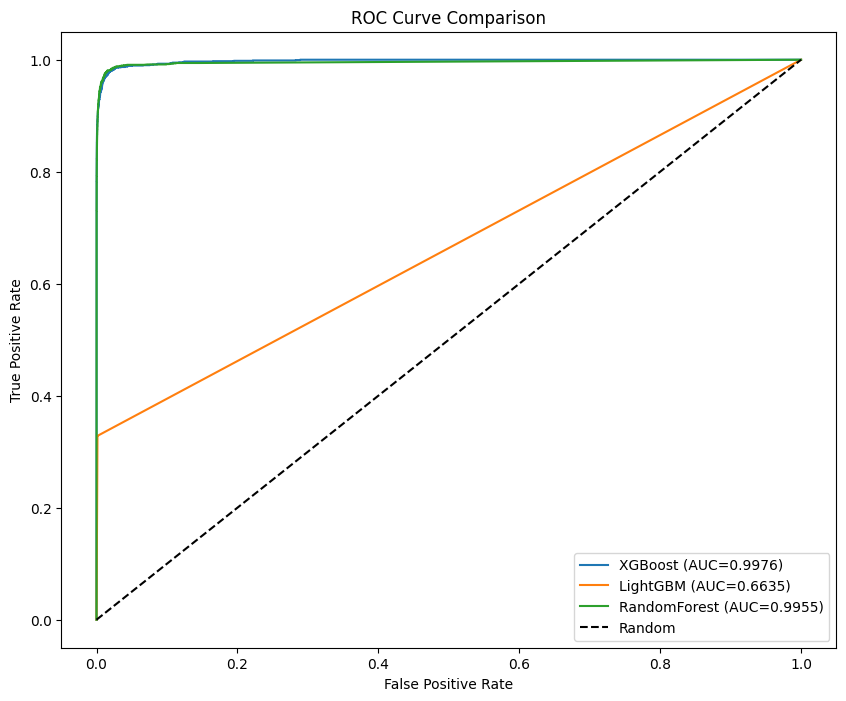

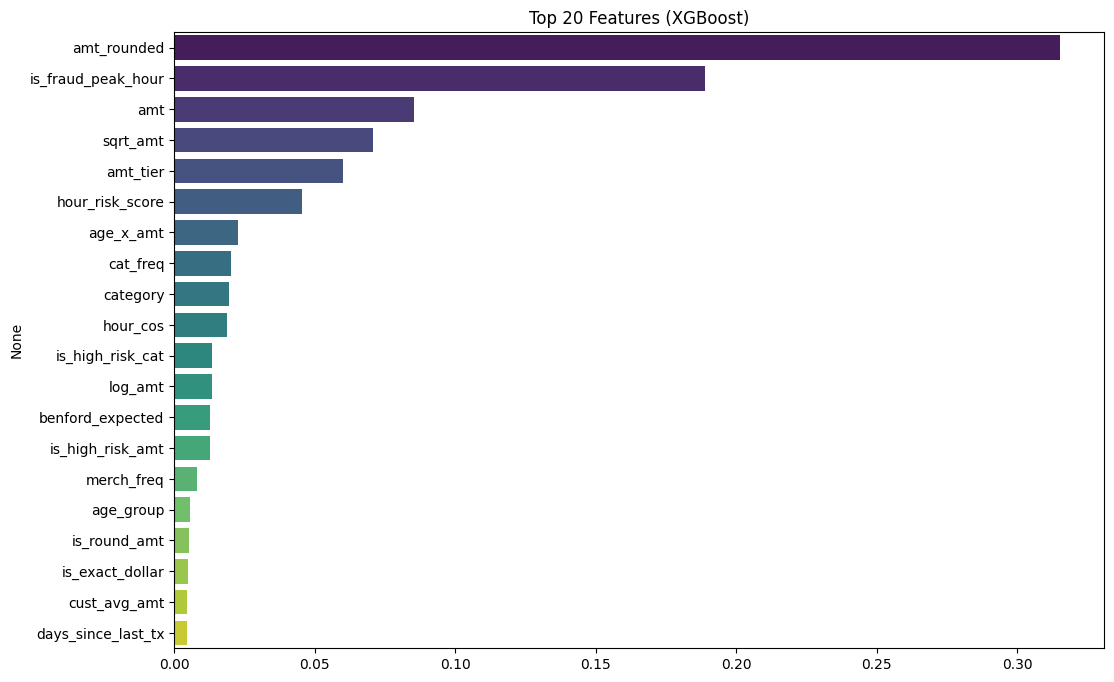

In [10]:
# 11.1 ROC Curve Comparison
plt.figure(figsize=(10, 8))
valid_results = [r for r in [res_xgb, res_lgb, res_rf] if r is not None]

for res in valid_results:
    fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, res['y_prob'])
    plt.plot(fpr, tpr, label=f"{res['Model']} (AUC={res['AUC']:.4f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.savefig(f"{METRICS_PATH}/roc_comparison.png")
plt.show()

# 11.2 Feature Importance (XGBoost)
if model_xgb:
    importances = model_xgb.feature_importances_
    feature_names = prep_final.get_feature_names_out()
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
    plt.title('Top 20 Features (XGBoost)')
    plt.savefig(f"{METRICS_PATH}/feature_importance_xgb.png")
    plt.show()

## 12. Business Cost & Selection
Simulation: False Negative Cost = \$500, False Positive = \$10.
We select the model that minimizes Total Cost.

In [11]:
COST_FN = 500
COST_FP = 10

def calc_cost_safe(row, y_true):
    # Approx cost calculation using metrics data if strictly model not available
    # But we want CM based.
    return 0 

def calc_cost(name, model, preprocessor, X, y):
    if model is None:
        return np.inf
    y_pred = model.predict(preprocessor.transform(X))
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return fn * COST_FN + fp * COST_FP

results_df['Real_Cost'] = results_df['Model'].apply(
    lambda name: calc_cost(name, 
                           model_xgb if name=='XGBoost' else (model_lgb if name=='LightGBM' else model_rf),
                           prep_final, X_test, y_test)
)

display(results_df[['Model', 'Recall', 'Precision', 'Real_Cost']])

best_model_name = results_df.sort_values('Real_Cost').iloc[0]['Model']
print(f"⭐ BEST MODEL SELECTED: {best_model_name}")

,Model,Recall,Precision,Real_Cost
0,XGBoost,0.825098,0.937223,135350
1,LightGBM,0.328349,0.587893,520040
2,RandomForest,0.773732,0.943695,174710


⭐ BEST MODEL SELECTED: XGBoost


## 13. Artifact Registry
Generating Model Card and Comparison JSON.

In [12]:
registry = {
    "timestamp": str(pd.Timestamp.now()),
    "dataset_info": {
        "train_size": len(X_train),
        "test_size": len(X_test),
        "fraud_rate": fraud_rate
    },
    "best_model": best_model_name,
    "models": {}
}

models_map = {"XGBoost": (res_xgb, best_params_xgb), 
              "LightGBM": (res_lgb, best_params_lgb), 
              "RandomForest": (res_rf, best_params_rf)}

for name, (res, params) in models_map.items():
    if res is not None:
        registry["models"][name] = {
            "metrics": {k: float(v) if isinstance(v, (int, float, np.number)) else str(v) for k,v in res.items() if k != 'y_prob'},
            "best_params": params
        }

with open(f"{METRICS_PATH}/model_registry.json", "w") as f:
    json.dump(registry, f, indent=4)

print("Pipeline complete. All artifacts saved.")

Pipeline complete. All artifacts saved.
